In [54]:
import numpy as np
import pandas as pd
from math import sqrt


import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split,cross_val_score,cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from sklearn import linear_model
from sklearn.linear_model import Lasso,LassoCV,LassoLarsCV 
from sklearn.neural_network import MLPRegressor


In [55]:
returns = pd.read_excel("Returns_Clean.xlsx", index_col = 'Dates')
returns.index = pd.to_datetime(returns.index, format='%Y%m%d')
returns

,55976,41072,27748,75259,40970,62519,21792,54084,55511,10302,...,63829,44986,11891,22752,27780,59379,75162,27705,54594,48725
Dates,,,,,,,,,,,,,,,,,,,,,
1993-04-01,-0.019685,0.019391,-0.007282,-0.003891,0.083333,0.027027,0.005348,0.020000,-0.010417,-0.025000,...,0.108108,-0.019048,-0.017857,-0.028269,0.000000,0.006173,-0.023669,0.000000,0.031915,0.014433
1993-04-02,-0.020080,0.002717,-0.002445,0.058594,-0.038462,-0.026316,-0.007979,-0.019608,-0.021053,-0.025641,...,0.000000,-0.016181,-0.031818,-0.010909,0.000000,-0.020450,0.012121,-0.032609,0.020619,-0.010163
1993-04-05,-0.024590,-0.006775,-0.002451,0.022140,-0.040000,0.027027,0.005362,0.000000,0.021505,0.026316,...,-0.048780,-0.003289,0.032864,0.003676,-0.005102,0.018789,-0.005988,-0.011236,-0.010101,0.026694
1993-04-06,-0.067227,0.009550,-0.007371,0.025271,0.041667,0.052632,0.005333,0.000000,0.000000,0.038462,...,-0.025641,-0.023102,-0.009091,-0.007326,0.005128,0.002049,-0.024096,-0.011364,-0.010204,0.014000
1993-04-07,0.000000,0.005405,0.000000,0.021127,0.040000,-0.050000,0.002653,0.000000,0.010526,0.012346,...,-0.013158,0.016892,0.018349,0.000000,0.010204,0.014315,0.000000,0.011494,0.000000,0.005917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-12-22,0.014493,0.025678,0.003630,0.077551,0.000000,0.011811,-0.004354,0.035714,0.012285,0.069767,...,0.000000,0.016418,-0.007426,-0.021622,-0.029727,-0.006281,0.002066,0.100446,-0.010989,0.026415
2000-12-26,-0.035714,0.034771,0.007233,-0.056818,-0.063830,0.060311,0.029155,-0.034483,0.026699,0.006211,...,0.027027,0.004405,0.034913,0.024171,0.026961,0.022756,-0.008247,-0.034483,-0.027778,0.003676
2000-12-27,0.038272,0.001344,0.001795,0.000000,0.090909,-0.042202,0.000000,-0.035714,0.021277,0.015432,...,0.052632,0.038012,0.069880,0.000000,0.047733,0.014833,0.022869,0.027311,0.005714,0.028083


In [64]:
# inputs: result -- model result dataframe
#         model_name -- 'LR', 'LASSO', 'RF', 'MLPR'

def classify(result, model_name):
    
    returns_class['{}_pred'.format(model_name)] = np.zeros(length)
    for t in tqdm(result.index):
        returns_t = returns.loc[t]
        p_25 = np.percentile(returns_t, 25)
        p_50 = np.percentile(returns_t, 50)
        p_75 = np.percentile(returns_t, 75)
        
        if result['Predicted Returns'][t] <= p_25:
            returns_class.loc[[t],['{}_pred'.format(model_name)]] = 1
        if p_25 < result['Predicted Returns'][t] <= p_50:
            returns_class.loc[[t],['{}_pred'.format(model_name)]] = 2
        if p_50 < result['Predicted Returns'][t] <= p_75:
            returns_class.loc[[t],['{}_pred'.format(model_name)]] = 3
        else:
            returns_class.loc[[t],['{}_pred'.format(model_name)]] = 4

    return returns_class['{}_pred'.format(model_name)]

In [65]:
# Import result from Linear Regression model
LR_result = pd.read_csv("linear_result.csv", index_col = 'Date')
LR_result.index = pd.to_datetime(LR_result.index, format='%Y%m%d')
length = len(LR_result)
# Classify RF prediction returns
returns_class = pd.DataFrame(index = LR_result.index)
classify(LR_result, 'LR')

Date
1994-04-06    4.0
1994-04-07    3.0
1994-04-08    4.0
1994-04-11    3.0
1994-04-12    3.0
             ... 
2000-12-22    4.0
2000-12-26    4.0
2000-12-27    4.0
2000-12-28    4.0
2000-12-29    3.0
Name: LR_pred, Length: 1702, dtype: float64

In [66]:
# Import result from LASSO model 
LASSO_result = pd.read_excel("LASSO_portfolio_results.xlsx", index_col = 'Date')
LASSO_result.index = pd.to_datetime(LASSO_result.index, format='%Y%m%d')

# Classify LASSO prediction returns
classify(LASSO_result, 'LASSO')



Date
1994-04-06    3.0
1994-04-07    4.0
1994-04-08    3.0
1994-04-11    3.0
1994-04-12    3.0
             ... 
2000-12-22    4.0
2000-12-26    4.0
2000-12-27    4.0
2000-12-28    4.0
2000-12-29    4.0
Name: LASSO_pred, Length: 1702, dtype: float64

In [68]:
# Import result from Random Forest model
RF_result = pd.read_csv("random_forest_result.csv", index_col = 'Date')
RF_result.index = pd.to_datetime(RF_result.index, format='%Y%m%d')
# Classify RF prediction returns
classify(RF_result, 'RF')

Date
1994-04-06    3.0
1994-04-07    4.0
1994-04-08    4.0
1994-04-11    4.0
1994-04-12    4.0
             ... 
2000-12-22    4.0
2000-12-26    3.0
2000-12-27    4.0
2000-12-28    4.0
2000-12-29    4.0
Name: RF_pred, Length: 1702, dtype: float64

In [123]:
# Import result from Random Forest model
MLPR_result = pd.read_excel("Grid-MLPR_portfolio_results.xlsx", index_col = 'Date')
MLPR_result.index = pd.to_datetime(MLPR_result.index, format='%Y%m%d')
# Classify RF prediction returns
classify(MLPR_result, 'MLPR')

Date
1994-04-06    4.0
1994-04-07    4.0
1994-04-08    4.0
1994-04-11    4.0
1994-04-12    4.0
             ... 
2000-12-22    4.0
2000-12-26    4.0
2000-12-27    4.0
2000-12-28    4.0
2000-12-29    4.0
Name: MLPR_pred, Length: 1702, dtype: float64

In [67]:
# Classification on actual value of portfolio returns

returns_class['portfolio'] = np.zeros(length)

for t in tqdm(LR_result.index):
#      Find 25, 50, 75 percentile of 100 stock returns at time t
    returns_t = returns.loc[t]
    p_25 = np.percentile(returns_t, 25)
    p_50 = np.percentile(returns_t, 50)
    p_75 = np.percentile(returns_t, 75)
#     print(p_25)
    if LR_result['Portfolio Returns'][t] <= p_25:
        returns_class.loc[[t],['portfolio']] = 1
    if p_25 < LR_result['Portfolio Returns'][t]<= p_50:
        returns_class.loc[[t],['portfolio']] = 2
    if p_50 < LR_result['Portfolio Returns'][t] <= p_75:
        returns_class.loc[[t],['portfolio']] = 3
    else:
        returns_class.loc[[t],['portfolio']] = 4
returns_class['portfolio']  

Date
1994-04-06    4.0
1994-04-07    3.0
1994-04-08    4.0
1994-04-11    4.0
1994-04-12    4.0
             ... 
2000-12-22    4.0
2000-12-26    3.0
2000-12-27    4.0
2000-12-28    3.0
2000-12-29    4.0
Name: portfolio, Length: 1702, dtype: float64

In [71]:
returns_class['benchmark'] = returns_class.portfolio.shift(1)

In [124]:
returns_class

,LR_pred,LASSO_pred,portfolio,RF_pred,benchmark,MLPR_pred
Date,,,,,,
1994-04-06,4.0,3.0,4.0,3.0,NaN,4.0
1994-04-07,3.0,4.0,3.0,4.0,4.0,4.0
1994-04-08,4.0,3.0,4.0,4.0,3.0,4.0
1994-04-11,3.0,3.0,4.0,4.0,4.0,4.0
1994-04-12,3.0,3.0,4.0,4.0,4.0,4.0
...,...,...,...,...,...,...
2000-12-22,4.0,4.0,4.0,4.0,4.0,4.0
2000-12-26,4.0,4.0,3.0,3.0,4.0,4.0
2000-12-27,4.0,4.0,4.0,4.0,3.0,4.0


In [89]:
accuracy = pd.DataFrame(index = returns_class.index)
accuracy['benchmark_count'] = np.zeros(length)
count = 0
for t in tqdm(returns_class.index):    
    if returns_class['benchmark'][t] == returns_class['portfolio'][t]:
        count += 1
        accuracy.loc[[t], ['benchmark_count']]= count
    else:
        accuracy.loc[[t], ['benchmark_count']]= count
            
            

,benchmark_count
Date,
1994-04-06,0.0
1994-04-07,0.0
1994-04-08,0.0
1994-04-11,1.0
1994-04-12,2.0
...,...
2000-12-22,903.0
2000-12-26,903.0
2000-12-27,903.0


In [125]:
for i in ['LR', 'LASSO', 'RF','MLPR']:
    accuracy['{}_count'.format(i)] = np.zeros(length)
    count = 0
    for t in tqdm(returns_class.index):
        if returns_class['{}_pred'.format(i)][t] == returns_class['portfolio'][t]:
            count += 1
            accuracy['{}_count'.format(i)][t] = count
        else:
            accuracy['{}_count'.format(i)][t] = count
  


In [126]:
accuracy

,benchmark_count,LR_count,LASSO_count,RF_count,MLPR_count
Date,,,,,
1994-04-06,0.0,1.0,0.0,0.0,1.0
1994-04-07,0.0,2.0,0.0,0.0,1.0
1994-04-08,0.0,3.0,0.0,1.0,2.0
1994-04-11,1.0,3.0,0.0,2.0,3.0
1994-04-12,2.0,3.0,0.0,3.0,4.0
...,...,...,...,...,...
2000-12-22,903.0,984.0,971.0,1405.0,957.0
2000-12-26,903.0,984.0,971.0,1406.0,957.0
2000-12-27,903.0,985.0,972.0,1407.0,958.0


In [127]:
benchmark_acc = '{:.0%}'.format(accuracy['benchmark_count'][-1]/length)
percentage_acc = pd.DataFrame([benchmark_acc],columns = ['benchmark'])

for i in ['LR', 'LASSO', 'RF', 'MLPR']:
    acc = pd.DataFrame(['{:.0%}'.format(accuracy['{}_count'.format(i)][-1]/length)], columns = ['{}_acc'.format(i)])
    percentage_acc = pd.concat([percentage_acc, acc], axis = 1)
    
percentage_acc


,benchmark,LR_acc,LASSO_acc,RF_acc,MLPR_acc
0,53%,58%,57%,83%,56%


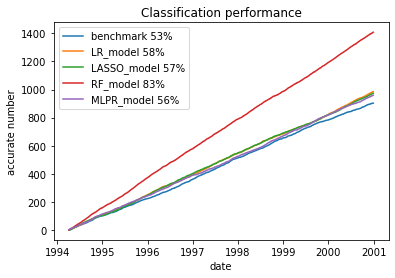

In [128]:
plt.figure()
plt.plot(accuracy['benchmark_count'], label = 'benchmark ' + percentage_acc['benchmark'][0])
for i in ['LR', 'LASSO', 'RF', 'MLPR']:
    plt.plot(accuracy['{}_count'.format(i)], label = '{}_model '.format(i) + percentage_acc['{}_acc'.format(i)][0])

plt.legend()
plt.xlabel('date')
plt.ylabel('accurate number')
plt.title('Classification performance')


plt.show()